In [3]:
from sqlalchemy import Column, Integer, MetaData, Table, create_engine, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import select
from sqlalchemy import func

In [4]:
engine = create_engine('postgres://douglas@postgis:5432/AQI', client_encoding='utf8')
Session = sessionmaker(bind=engine)
session = Session()

metadata = MetaData()
metadata.reflect(engine, only=['locs_airlocation', 'locs_airmeasurement'])
Base = automap_base(metadata=metadata)
Base.prepare()

AirLocation, AirMeasurement = Base.classes.locs_airlocation, Base.classes.locs_airmeasurement

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


In [5]:
# Select some airlocation with bad aqi
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_id = session.execute(s).scalar()
s = select([AirLocation]).where(AirLocation.id == some_airlocation_id)
some_airlocation = session.execute(s).first()
print("{}, {}".format(some_airlocation.short_name, some_airlocation.en_country_name))
s = select([func.count(AirMeasurement.id)]).where(
    AirMeasurement.airlocation_id == some_airlocation_id
).where(
    AirMeasurement.aqi != None
)
some_airlocation_measurement_count = session.execute(s).first()[0]
print("{} AQI measurements for this city".format(some_airlocation_measurement_count))

Mudanjiang, China


37663 AQI measurements for this city


In [38]:
# Collect the measurements for that AirLocation into a
# numpy array like [(min of day, day of year, day of week, day of month, aqi)]
s = select([AirMeasurement.id, AirMeasurement.measurement_datetime, AirMeasurement.aqi]).where(
    AirMeasurement.airlocation_id == 48
).where(
    AirMeasurement.aqi != None
).order_by(AirMeasurement.id.asc())

import numpy as np
import pandas as pd
measurements = pd.read_sql(s, engine)

In [67]:
def get_normalized_time_inputs(dt):
    return [
        # minute of day
        ((dt.time().hour * 60) + dt.time().minute) / 1440,
        # day of the year 
        dt.timetuple().tm_yday / 365,
        # day of the week, from 0 to 6
        dt.date().weekday() / 6,
        # day of the month
        dt.date().day / 31,
    ]
measurements['minute_of_day'], \
measurements['day_of_year'], \
measurements['day_of_week'], \
measurements['day_of_month'] = \
    zip(*measurements["measurement_datetime"].map(get_normalized_time_inputs))

# This is a common AQI ceiling for prediction/presentation, and appropriate for this city.
MAX_AQI = 300
def get_normalized_aqi(aqi):
    if not aqi:
        return 0
    return min(aqi, MAX_AQI) / 300

def get_denormalized_aqi(normalized_aqi):
    try:
        if not normalized_aqi or normalized_aqi <= 0:
            return 0
        return round(normalized_aqi * 300)
    except Exception:
        #print(normalized_aqi)
        return 0

measurements['normalized_aqi'] = measurements['aqi'].map(get_normalized_aqi)

In [44]:
# Generate the baseline predictions
# (The prediction is the previous AQI measurement)
measurements['baseline_pred_aqi'] = measurements.aqi.shift(1)

In [45]:
# Perform test-train split
from sklearn.cross_validation import train_test_split
import itertools
feature_columns = ['minute_of_day', 'day_of_year', 'day_of_week', 'day_of_month']
# keep the id and baseline through the split to graph results later
x_all = measurements[list(itertools.chain(feature_columns, ['id', 'baseline_pred_aqi', 'aqi']))]
y_all = measurements['normalized_aqi']
y_all.columns = ['actual_aqi']
num_train = int(some_airlocation_measurement_count * 0.75)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, train_size=num_train)

In [48]:
# Input to SVM model
import time

def train_classifier(clf, x_train, y_train):
    print("Training {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(x_train[feature_columns], y_train)
    end = time.time()
    print("Done!\nTraining time (secs): {:.3f}".format(end - start))

from sklearn import svm
clf = svm.SVR()
train_classifier(clf, x_train, list(y_train))

Training SVR...


Done!
Training time (secs): 16.349


In [52]:
def predict_labels(clf, features, target):
    print("Predicting labels using {}...".format(clf.__class__.__name__))
    start = time.time()
    y_pred = clf.predict(features[feature_columns])
    end = time.time()
    print("Done!\nPrediction time (secs): {:.3f}".format(end - start))
    return y_pred

print("Making training predictions...")
y_train_pred = predict_labels(clf, x_train, y_train)
print("Making test predictions...")
y_test_pred = predict_labels(clf, x_test, y_test)

Making training predictions...
Predicting labels using SVR...


Done!
Prediction time (secs): 6.953
Making test predictions...
Predicting labels using SVR...


Done!
Prediction time (secs): 2.256


In [53]:
from sklearn.metrics import mean_squared_error

# Score predictions
print("F1 score for training set: {}".format(mean_squared_error(y_train, y_train_pred)))

print("F1 score for test set: {}".format(mean_squared_error(y_test, y_test_pred)))

F1 score for training set: 0.012316876902791799
F1 score for test set: 0.012489009251142387


In [76]:
# Gather all the predictions together to plot
y_test_pred_df = pd.DataFrame({'pred_aqi': y_test_pred})

test_results = x_test[['id', 'baseline_pred_aqi', 'aqi']].join(y_test_pred_df).sort(['id'])
test_results['pred_aqi'] = test_results['pred_aqi'].map(get_denormalized_aqi)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [80]:
print(test_results[1500:])

              id  baseline_pred_aqi  aqi  pred_aqi
6009    14836288              107.0  107        74
6015    14852100              107.0  107        90
6016    14857112              107.0  107        93
6022    14873000              107.0  107        86
6024    14878304              107.0  107        73
6029    14889299              107.0  107       157
6034    14904771              107.0  107        96
6036    14910072              107.0  107       120
6040    14920659              107.0  107        74
6043    14926324              107.0  107        78
6045    14931375              107.0  107        83
6046    14936552              107.0  107        68
6051    14947526              107.0  107        91
6062    14979030              107.0  107        92
6064    14984317              107.0  107        61
6065    14984336              107.0  107        91
6066    14989512              107.0  107       131
6067    14989734              107.0  107        70
6070    15000104              1

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[0.0, 130000000.0, 0.0, 250.0]

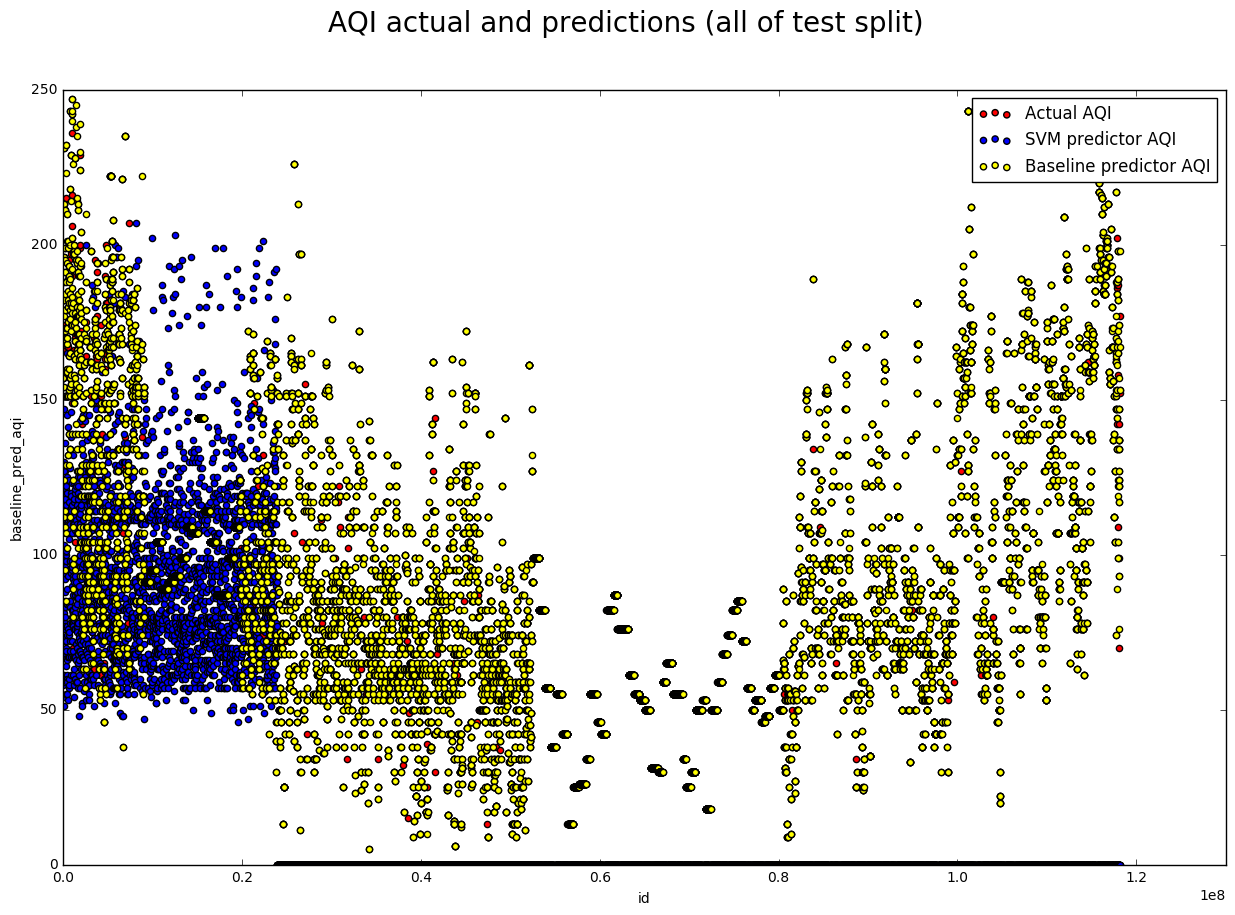

In [69]:
import matplotlib.pyplot as plt
aqi_graph = test_results.plot.scatter(x='id', y='aqi', label="Actual AQI", color="Red")
test_results.plot.scatter(x='id', y='pred_aqi', label="SVM predictor AQI", ax=aqi_graph, color="Blue")
test_results.plot.scatter(x='id', y='baseline_pred_aqi', label="Baseline predictor AQI", ax=aqi_graph, color="Yellow")
fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("AQI actual and predictions (all of test split)", fontsize=20)
aqi_graph.axis([0.0, 130000000.0, 0.0, 250.0])

[0.0, 5000000.0, 0.0, 250.0]

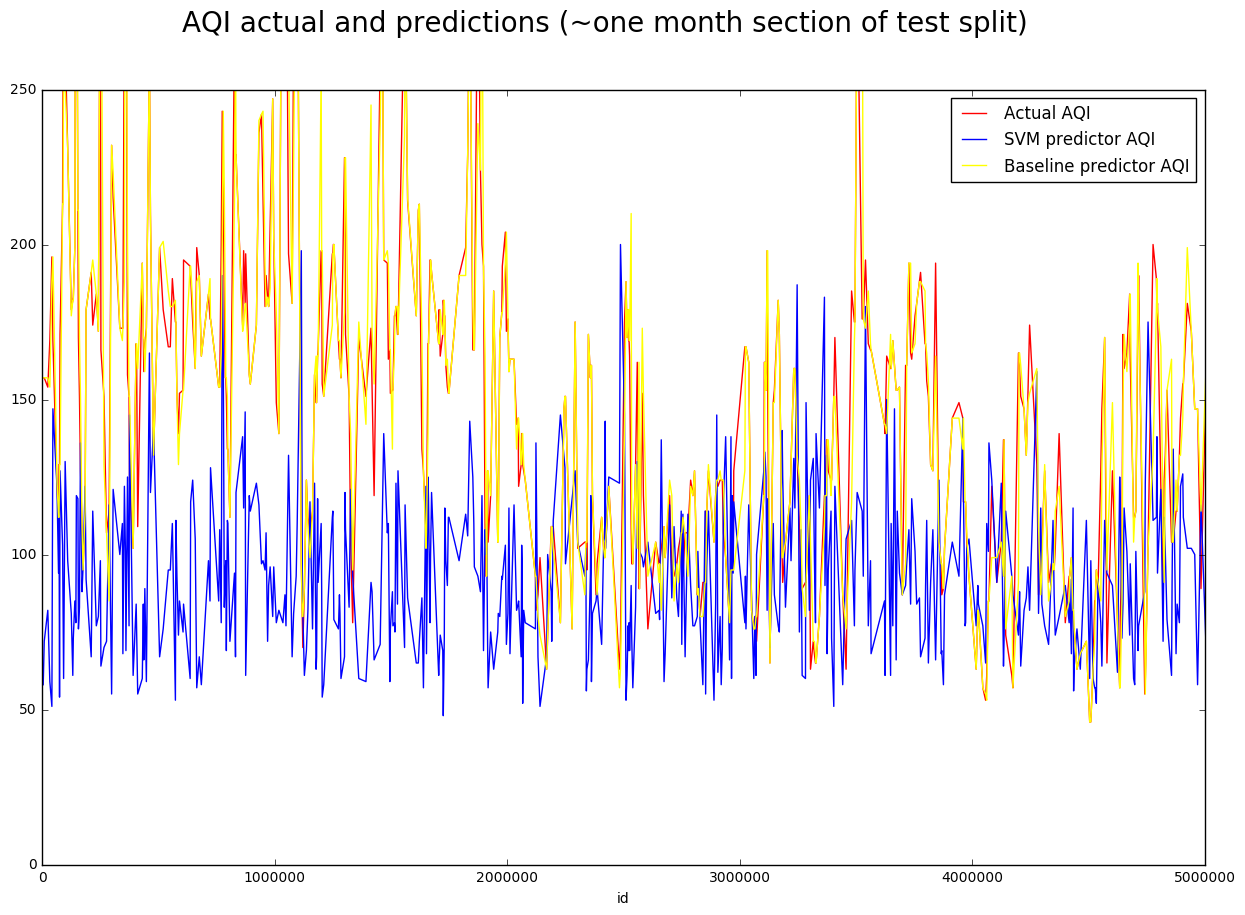

In [74]:
aqi_graph = test_results.plot(x='id', y='aqi', label="Actual AQI", color="Red")
test_results.plot(x='id', y='pred_aqi', label="SVM predictor AQI", ax=aqi_graph, color="Blue")
test_results.plot(x='id', y='baseline_pred_aqi', label="Baseline predictor AQI", ax=aqi_graph, color="Yellow")
fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("AQI actual and predictions (~one month section of test split)", fontsize=20)
aqi_graph.axis([0.0, 5000000.0, 0.0, 250.0])

[5000000.0, 6000000.0, 0.0, 250.0]

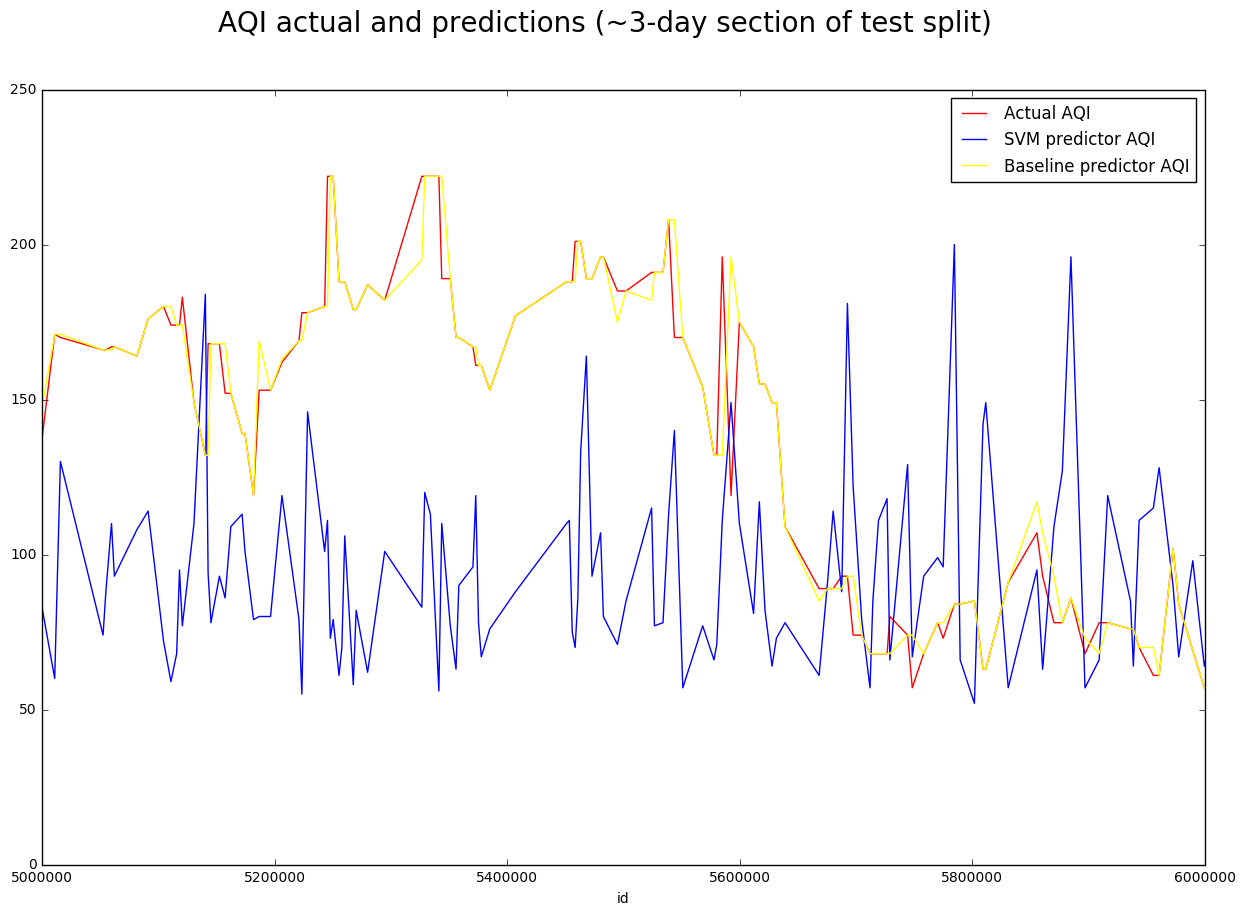

In [75]:
aqi_graph = test_results.plot(x='id', y='aqi', label="Actual AQI", color="Red")
test_results.plot(x='id', y='pred_aqi', label="SVM predictor AQI", ax=aqi_graph, color="Blue")
test_results.plot(x='id', y='baseline_pred_aqi', label="Baseline predictor AQI", ax=aqi_graph, color="Yellow")
fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("AQI actual and predictions (~3-day section of test split)", fontsize=20)
aqi_graph.axis([5000000.0, 6000000.0, 0.0, 250.0])

In [81]:
# fix bad data date ranges
# fix null predictions
